TOC POSTPROCESSING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from glob import glob
import os
%matplotlib widget

Function to merge Picarro files 

In [2]:
def merge_picarro_files(root_folder):
    #list to store data
    all_data = []

    # loop through day subfolders
    for day_folder in os.listdir(root_folder):
        day_path = os.path.join(root_folder, day_folder)

        #loop through files of each day folder
        for file_name in os.listdir(day_path):
            file_path = os.path.join(day_path, file_name)
        
        # read .dat using fwf
            df = pd.read_csv(file_path, sep='\s+') 

            
            # append data 
            all_data.append(df)

    # combine into a df
    merged_df = pd.concat(all_data, ignore_index=True)

    # create datetime column 
    merged_df['datetime'] = pd.to_datetime(merged_df['DATE'] + ' ' + merged_df['TIME'], errors='coerce')

    # drop date and time columns 
    merged_df.drop(columns=['DATE', 'TIME'], inplace=True)

    #  datetime first
    columns = ['datetime'] + [col for col in merged_df.columns if col != 'datetime']
    merged_df = merged_df[columns]

    return merged_df

Example use 

In [3]:
root_folder = os.path.expanduser('C:/Users/ica/OneDrive - Plymouth Marine Laboratory/vscode/TOC_analysis/data/11')  # yourpath
picarro_df = merge_picarro_files(root_folder)


In [4]:
picarro_df.set_index('datetime', inplace=True)


Function for QC 

In [5]:
def qc(df):
    
    df['CO2_corrected'] = (df['CO2_dry'] + 0.63141) / 0.99357
    df['CH4_corrected'] = df['CH4_dry'] * (2.024799 / 2.0238)
    return df

Create df for TOC calculations 

In [6]:
def TOC_df(df):
    """
    Makes df for TOC calculations, averages catalyst and ambient times
    
    Args:
        df: df with qc measurements
    
    Returns:
        df to do TOC calculations 
    """
    # lists for storing averages
    avg_times = []
    avg_co2_ambient = []
    avg_co2_catalyst = []
    avg_ch4_ambient = []
    avg_ch4_catalyst = []
    avg_co_ambient = []
    avg_co_catalyst = []

    # detect for valve changes
    valve_change = df[(df['solenoid_valves'] != 2.0) & (df['solenoid_valves'] != 0.0)]  # valve =2 is catalyst
                                                                                       # valve = 0 is ambient

    # averages before valve changes
    for i in valve_change.index:
        #  time window (25s before valve change, ending 2s before)
        end_time = i - pd.Timedelta(seconds=2)
        start_time = end_time - pd.Timedelta(seconds=42)
        
        # get data in the main df within time window
        window_df = df[(df.index > start_time) & (df.index < end_time)]
        
        # averages
        avg_co2 = window_df['CO2_corrected'].mean()
        avg_ch4 = window_df['CH4_corrected'].mean()
        avg_co = window_df['CO'].mean()
        avg_valve = window_df['solenoid_valves'].mean()
        avg_time_val = window_df.index.mean()
        avg_times.append(avg_time_val)

        # sort appropriate lists based on valve state
        if avg_valve == 2.0:  # catalyst
            avg_co2_catalyst.append(avg_co2)
            avg_ch4_catalyst.append(avg_ch4)
            avg_co_catalyst.append(avg_co)
            avg_co2_ambient.append(np.nan)
            avg_ch4_ambient.append(np.nan)
            avg_co_ambient.append(np.nan)
        elif avg_valve == 0.0:  # ambient
            avg_co2_ambient.append(avg_co2)
            avg_ch4_ambient.append(avg_ch4)
            avg_co_ambient.append(avg_co)
            avg_co2_catalyst.append(np.nan)
            avg_ch4_catalyst.append(np.nan)
            avg_co_catalyst.append(np.nan)

    # create results df
    TOC_df = pd.DataFrame({
        'datetime': avg_times,
        'avg_co2_ambient': avg_co2_ambient,
        'avg_ch4_ambient': avg_ch4_ambient,
        'avg_co_ambient': avg_co_ambient,
        'avg_co2_catalyst': avg_co2_catalyst,
        'avg_ch4_catalyst': avg_ch4_catalyst,
        'avg_co_catalyst': avg_co_catalyst
    })

    return TOC_df.set_index('datetime')

Calculate TOC

In [7]:
def calculate_toc(TOC_df):
    """
    calculate final TOC values 
    
    Args:
        TOC_df: DataFrame with averaged values
    
    Returns:
        DataFrame with TOC results
    """
    toc_results = []

    # process in pairs (ambient + catalyst)
    for i in range(0, len(TOC_df), 2):
        pair = TOC_df.iloc[i:i+2]
        # sum catalyst and ambient values
        sum_catalyst = pair[['avg_co2_catalyst', 'avg_ch4_catalyst', 'avg_co_catalyst']].sum().sum()
        sum_ambient = pair[['avg_co2_ambient', 'avg_ch4_ambient', 'avg_co_ambient']].sum().sum()
        # calculate TOC
        toc = sum_catalyst - sum_ambient
        # store result with mean timestamp
        toc_results.append((pair.index.mean(), toc))

    return pd.DataFrame(toc_results, columns=['datetime', 'TOC']).set_index('datetime')


Example use 

In [8]:
start_time = datetime.datetime(2024, 11, 27, 10, 0, 0)
end_time = datetime.datetime(2024, 11, 28, 12, 0, 0)

df = picarro_df.loc[start_time:end_time]

# Apply QC
df = qc(df)

# Generate TOC dataframe
df[df < 0] = 0
result = TOC_df(df)


C:\Users\ica\AppData\Local\Temp\ipykernel_18180\1696168454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CO2_corrected'] = (df['CO2_dry'] + 0.63141) / 0.99357
C:\Users\ica\AppData\Local\Temp\ipykernel_18180\1696168454.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CH4_corrected'] = df['CH4_dry'] * (2.024799 / 2.0238)
C:\Users\ica\AppData\Local\Temp\ipykernel_18180\1325996838.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

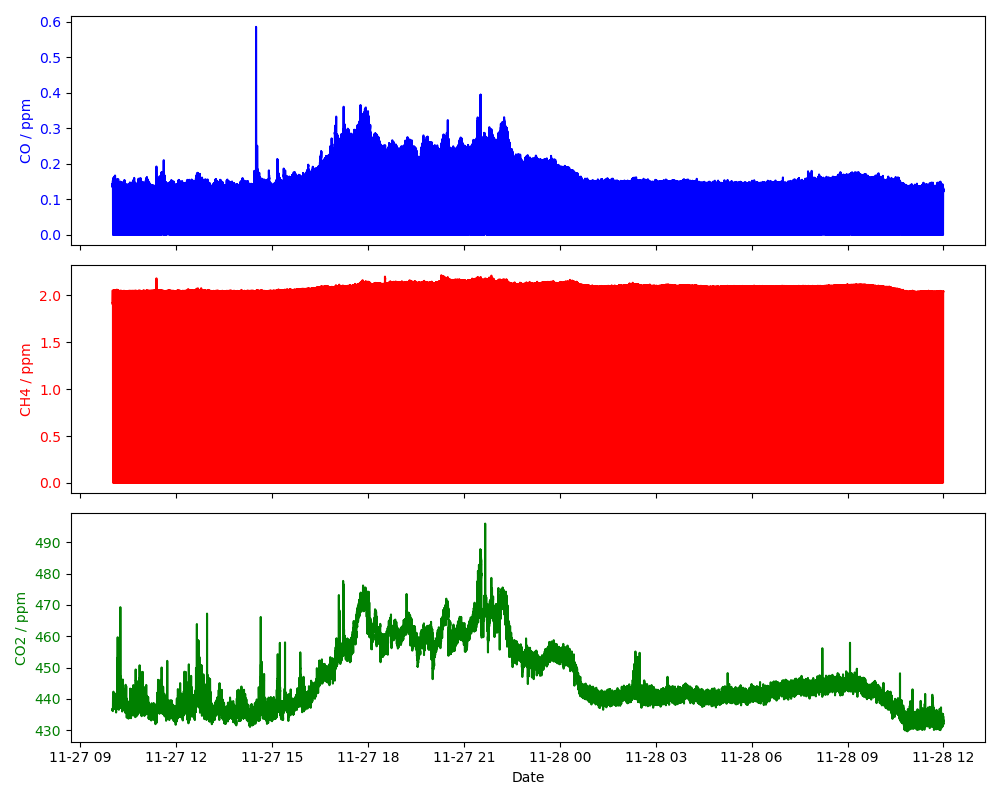

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10, 8))

# Plot for CO
ax1.plot(df.index, df.CO, label='CO / ppm', color='blue')
ax1.set_ylabel('CO / ppm', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot for CH4
ax2.plot(df.index, df.CH4_corrected, label='CH4 / ppm', color='red')
ax2.set_ylabel('CH4 / ppm', color='red')
ax2.tick_params(axis='y', labelcolor='red')
'''

# Plot for CO2
ax3.plot(df.index, df.solenoid_valves, label='CO2 / ppm', color='green')
ax3.set_xlabel('Date')
ax3.set_ylabel('Solenoid Valve, 0 = amb, 2 cat', color='green')
ax3.tick_params(axis='y', labelcolor='green')
'''

# Plot for CO2
ax3.plot(df.index, df.CO2_corrected, label='CO2 / ppm', color='green')
ax3.set_xlabel('Date')
ax3.set_ylabel('CO2 / ppm', color='green')
ax3.tick_params(axis='y', labelcolor='green')


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

C:\Users\ica\AppData\Local\Temp\ipykernel_18180\1760317858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df < 0] = 0
C:\Users\ica\AppData\Local\Temp\ipykernel_18180\1760317858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df < 0] = 0


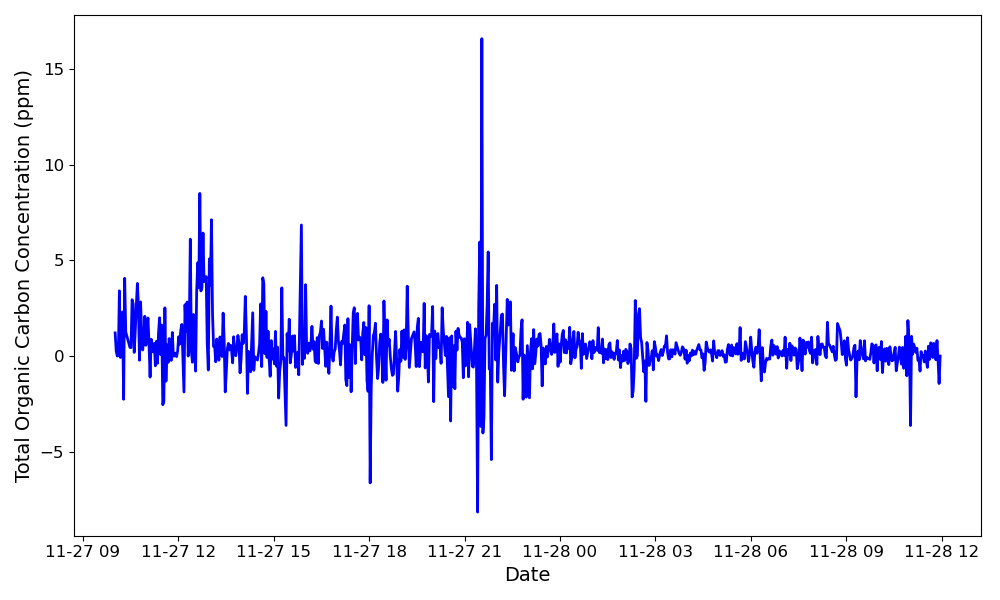

In [10]:
TOC_results_df = calculate_toc(result)
TOC_results_df = TOC_results_df[(TOC_results_df['TOC'] >= -10) & (TOC_results_df['TOC'] <= 100)]
df[df < 0] = 0

mean = TOC_results_df['TOC'].mean()

plt.figure(figsize=(10, 6))  # Adjust figure size for better clarity
plt.plot(TOC_results_df.index, TOC_results_df['TOC'], label='TOC Concentration', color='blue', linewidth=2)

# Add labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Organic Carbon Concentration (ppm)', fontsize=14)
#plt.title('Total Organic Carbon Concentration Over Time', fontsize=16)

# Customize x-axis ticks
plt.xticks(fontsize=12)  # Rotate dates for better readability
plt.yticks(fontsize=12)

# Add gridlines and legend
#plt.grid(True, linestyle='--', alpha=0.6)


# Tight layout to prevent clipping
plt.tight_layout()

# Save the figure (optional for publication)

# Show the plot
plt.show()

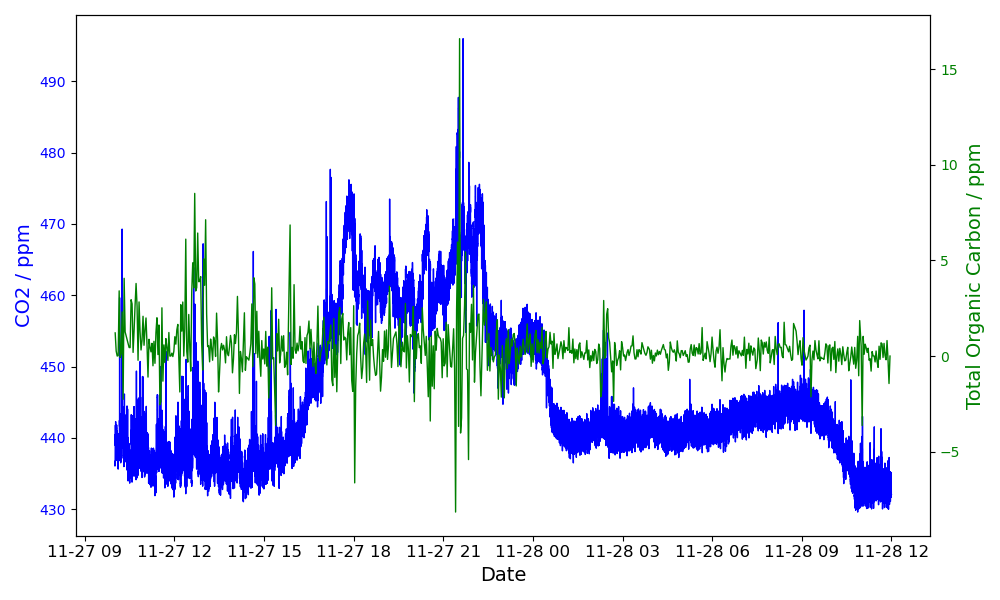

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

# Plot CO2 on the left y-axis
ax1.plot(df.index, df.CO2_corrected, label='CO2 / ppm', color='blue', linewidth=1)
ax1.set_ylabel('CO2 / ppm', color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Date', fontsize=14)
ax1.tick_params(axis='x', labelsize=12)

# Create a secondary y-axis for TOC
ax2 = ax1.twinx()
ax2.plot(TOC_results_df.index, TOC_results_df['TOC'], label='TOC / ppm', color='green', linewidth=1)
ax2.set_ylabel('Total Organic Carbon / ppm', color='green', fontsize=14)
ax2.tick_params(axis='y', labelcolor='green')

# Add gridlines and title

# Adjust layout to prevent overlap
plt.tight_layout()